In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!ls -la

total 911
drwx------ 2 root root   4096 Nov 20 12:09 'Colab Notebooks'
-rw------- 1 root root   2832 Dec 18 12:43  example_input.png
-rw------- 1 root root   2832 Dec 18 12:51  example_input.png.1
-rw------- 1 root root   2832 Dec 18 12:55  example_input.png.2
drwx------ 2 root root   4096 Dec 14 14:14  Football-computer-vision
drwx------ 2 root root   4096 Dec 14 09:59  Image-and-Video-Dehazing
drwx------ 2 root root   4096 Nov 24 20:52  .ipynb_checkpoints
drwx------ 2 root root   4096 Nov 24 20:52  Mediapipe
-rw------- 1 root root  12736 Dec 18 13:27  paint_with_words.py
drwx------ 2 root root   4096 Dec 16 17:12  paint-with-words-sd
-rw------- 1 root root  15762 Dec 18 13:00  rabbit-fireball.png
-rw------- 1 root root 424328 Dec 18 13:11  v1.4_output.png
-rw------- 1 root root 445053 Dec 18 13:13  v1.5_output.png


In [4]:
cd paint-with-words-sd/

/content/drive/MyDrive/paint-with-words-sd


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.5 MB/s 
     |████████████████████████████████| 7.6 MB 69.3 MB/s 


In [7]:
from paint_with_words import pww_load_tools

loaded = pww_load_tools("cuda:0", hf_model_path="CompVis/stable-diffusion-v1-4")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


CompVis/stable-diffusion-v1-4


Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

In [8]:
import torch

vae, unet, text_encoder, tokenizer, scheduler = loaded


def load_learned_embed_in_clip(
    learned_embeds_path, text_encoder, tokenizer, token=None
):
    loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")

    # separate token and the embeds
    trained_token = list(loaded_learned_embeds.keys())[0]
    embeds = loaded_learned_embeds[trained_token]

    # cast to dtype of text_encoder
    dtype = text_encoder.get_input_embeddings().weight.dtype

    # add the token in tokenizer
    token = token if token is not None else trained_token
    num_added_tokens = tokenizer.add_tokens(token)
    i = 1
    while num_added_tokens == 0:
        print(f"The tokenizer already contains the token {token}.")
        token = f"{token[:-1]}-{i}>"
        print(f"Attempting to add the token {token}.")
        num_added_tokens = tokenizer.add_tokens(token)
        i += 1

    # resize the token embeddings
    text_encoder.resize_token_embeddings(len(tokenizer))

    # get the id for the token and assign the embeds
    token_id = tokenizer.convert_tokens_to_ids(token)
    text_encoder.get_input_embeddings().weight.data[token_id] = embeds
    return token

In [11]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=49e835dc58ff26331c10455b49cf45f3c43d3830861b8a2677724a1690b89798
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [14]:
import os
import wget
import requests

model_id = "sd-concepts-library/midjourney-style"


# CODE FROM https://huggingface.co/spaces/sd-concepts-library/stable-diffusion-conceptualizer/blob/main/app.py.
# MIT Licensed

embeds_url = f"https://huggingface.co/{model_id}/resolve/main/learned_embeds.bin"
os.makedirs(model_id, exist_ok=True)
if not os.path.exists(f"{model_id}/learned_embeds.bin"):
    try:
        wget.download(embeds_url, out=model_id)
    except:
        print("Download failed. Trying with requests.")

token_identifier = f"https://huggingface.co/{model_id}/raw/main/token_identifier.txt"
response = requests.get(token_identifier)
token_name = response.text

In [15]:
tok = load_learned_embed_in_clip(
    f"{model_id}/learned_embeds.bin", text_encoder, tokenizer, token=token_name
)
tok

'<midjourney-style>'

Warning ratio 8 : tokens [-1] not found in text
Warning ratio 16 : tokens [-1] not found in text
Warning ratio 32 : tokens [-1] not found in text
Warning ratio 64 : tokens [-1] not found in text


  0%|          | 0/30 [00:00<?, ?it/s]

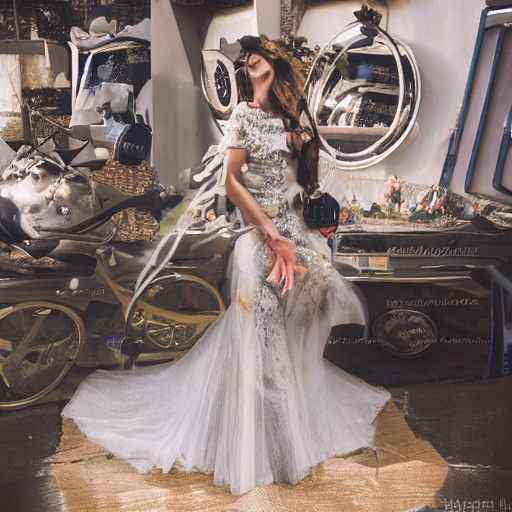

In [17]:
from paint_with_words import paint_with_words

img = paint_with_words(
    color_context={},  # Change here
    color_map_image=None,  # Change here
    input_prompt="",  # change here
    preloaded_utils=loaded,
    seed=1,
)

img